In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from superintendent import ClassLabeller

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors
%load_ext autoreload
%autoreload 2

# Load Datasets

In [108]:
data_dir = os.path.join('..', 'data')

file_names = ['positive_sites_0.02_20.pkl',
              'negative_sites_0.02_20.pkl',
              'tambopata_mine_-70.72,-69.8_-13.2,-12.57_0.01_10.pkl',
              'tambopata_mine_-70.72,-69.8_-13.2,-12.57_0.02_20.pkl']


file_names = ['84_px_bolivar_inception_bootstrap_v3.pkl']
data = []
for fn in file_names:
    with open(os.path.join(data_dir, fn), 'rb') as f:
        dataset = pickle.load(f)
        data += dataset

In [109]:
def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = np.clip((clipped - min_val) / (max_val - min_val) ** gamma, 0, 1)
    return stretched

def normalize(x):
    return (np.array(x)) / (3000)

In [110]:
rgb_img = []
for img in data:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    rgb_img.append(rgb)

print(np.shape(rgb_img))

(662, 84, 84, 3)


# Label Images

In [116]:
widget = ClassLabeller.from_images(
    features=rgb_img,
    canvas_size=(250, 250),
    options=['mine', 'uncertain', 'no mine']
)
widget

ClassLabeller(children=(HBox(children=(FloatProgress(value=0.0, description='Progress:', max=1.0),)), Box(chil…

In [120]:
labels = widget.new_labels
labels

['no mine',
 'mine',
 'mine',
 'uncertain',
 'no mine',
 'no mine',
 'uncertain',
 'no mine',
 'no mine',
 'uncertain',
 'mine',
 'mine',
 'mine',
 'mine',
 'uncertain',
 'no mine',
 'no mine',
 'mine',
 'mine',
 'mine',
 'no mine',
 'no mine',
 'no mine',
 'mine',
 'no mine',
 'no mine',
 'uncertain',
 'uncertain',
 'no mine',
 'no mine',
 'mine',
 'no mine',
 'uncertain',
 'mine',
 'mine',
 'uncertain',
 'no mine',
 'no mine',
 'mine',
 'no mine',
 'no mine',
 'uncertain',
 'mine',
 'no mine',
 'no mine',
 'no mine',
 'uncertain',
 'mine',
 'uncertain',
 'mine',
 'no mine',
 'no mine',
 'mine',
 'mine',
 'mine',
 'uncertain',
 'no mine',
 'mine',
 'uncertain',
 'mine',
 'uncertain',
 'no mine',
 'uncertain',
 'no mine',
 'no mine',
 'no mine',
 'no mine',
 'no mine',
 'uncertain',
 'no mine',
 'uncertain',
 'no mine',
 'uncertain',
 'no mine',
 'no mine',
 'no mine',
 'mine',
 'no mine',
 'mine',
 'no mine',
 'no mine',
 'uncertain',
 'no mine',
 'no mine',
 'no mine',
 'uncertain',


In [121]:
print(sum(np.array(labels) == 'mine'), "confirmed mines")
print(sum(np.array(labels) == 'no mine'), "false positives")
print(sum(np.array(labels) == 'uncertain'), "uncertain")

142 confirmed mines
228 false positives
102 uncertain


In [124]:
images_28_px = []
for image in np.array(data)[np.array(labels) == 'no mine']:
    for i in range(3):
        for j in range(3):
            img_subset = image[i*28:(i+1)*28, j*28:(j+1)*28]
            images_28_px.append(img_subset)
print(np.shape(images_28_px))

(2052, 28, 28, 12)


In [125]:
with open('../data/28_px_corrupted_images.pkl', 'wb') as f:
    pickle.dump(images_28_px, f)
with open('../data/28_px_corrupted_labels.pkl', 'wb') as f:
    pickle.dump(np.zeros(len(images_28_px)), f)

In [115]:
with open('../data/84_px_bolivar_inception_bootstrap_v3_positive.pkl', 'wb') as f:
    pickle.dump(np.array(data)[np.array(labels) == 'mine'], f)

In [52]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

def create_img_stack(patch_history):
    img_stack = []
    for date in patch_history:
        for site in patch_history[date]:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                if np.median(spectral_stack) > 0:
                    img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))
    return img_stack

def normalize(x):
    return (np.array(x)) / (3000)

In [59]:
data_dir = os.path.join('..', 'data')

fn = '2d_negative_sites_2018-01-01_12.pkl'
with open(os.path.join(data_dir, fn), 'rb') as f:
    dataset = pickle.load(f)

dates = list(dataset.keys())
sites = list(dataset[dates[0]].keys())
np.shape(dataset[dates[0]][sites[0]]['B2'])
img_stack = create_img_stack(dataset)
rgb_img = []
for img in img_stack:
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    rgb = stretch_histogram(normalize(rgb), 0.1, 1)
    rgb_img.append(rgb)

print(np.shape(rgb_img))

(772,)


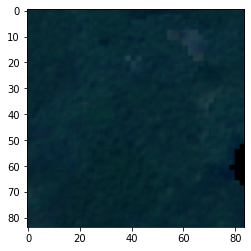

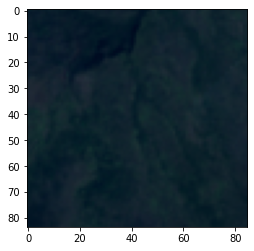

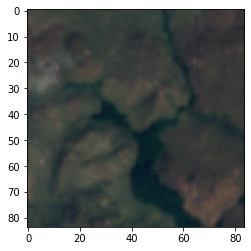

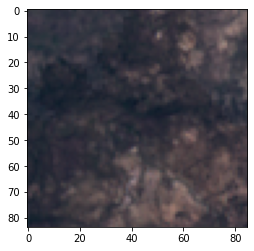

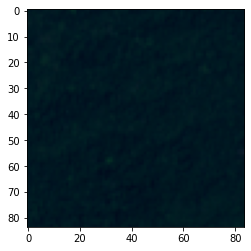

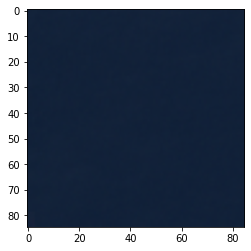

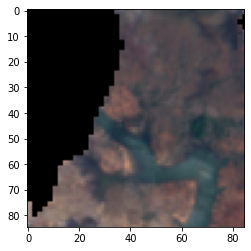

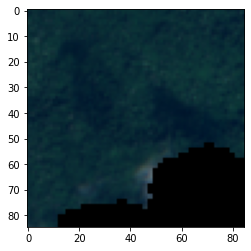

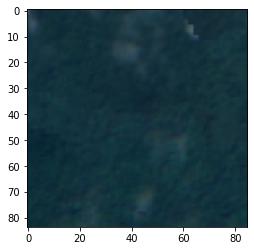

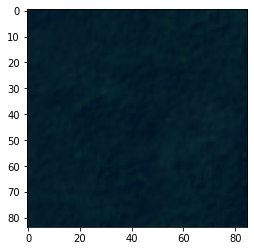

In [60]:
for img in rgb_img[:10]:
    plt.imshow(img)
    plt.show()